# RuMedSymptomRec

RuMedSymptomRec[1] - задача рекомендации симптомов по неполноценному медицинскому тексту.

## **Структура решения:**

1. Описание задачи и предметной области
1. Реализация метрики Hit@K
1. Подготовка данных
1. RuBERT
1. RuBioRoBERTa
1. Пример работы модели
1. Результаты
1. Ссылки на источники


## **1) Описание задачи и предметной области**

### Постановка задачи

По предложенному медицинскому тексту необходимо найти наиболее релевантый(точный) симптом. Количество возможных симптомов ограничено - можно предложить один из 141-го. В следствие этого задачу можно решать как задачу многоклассовой классификации .

### Данные
Данные[2] были получены из Сибирского государственного медицинского университета. Датасет состоит из 3300 примеров, разделенных на тренировочную, валидационную и тестовую модель(2470, 415, 415). Каждый пример представляет собой словарь:
> {'idx': 'q0d8323b',
> 'symptoms': 'на головокружение головную боль в области виска лба, заложенность носа, жар',
> 'code': 'головная боль в области лба'}.

 Где 'idx' - id текста, 'symptoms' - сам текст и 'code' - симптом которой надо предсказать(один из 141 предложенных таргетов).

### Метрики
Задача сводится к классификации текстов. Для каждого текста предложено выбрать один из 141-го симптомов.
Метрики предложенные организаторами - accuracy(hit@1) и hit@3.

$$ \text{Hits@K} = \frac{1}{N}\sum_{i=1}^N \, hit(y_i, top_i^k),$$

Было принято решение использовать такие же для оценки моделей.

### Модели

В качестве базовой модели была выбрана предобученная модель DeepPavlov/rubert-base-cased [3]. Это Bert предобученный на русском языке(википедия и новости). Состоит из 12 encoder слоев. В общей сложности 180М параметров.
Продвинутая модель - alexyalunin/RuBioRoBERTa [4]. RuBioRoBERTa - предобученная на русских медицинских текстах.


Модель принимает на вход токены(полученные предварительно с помощью токенайзера) и выдает числа(логиты) для каждого класса. Логиты ранжируются в порядке убывания. Класс который оказался на 1 месте - есть искомый симптом. Если надо получить несколько наиболее релевантных - берется топ@k.


Результаты[5] показанные организаторами на тестовой выборке: acc/hit@3  
* RuBERT: 18.55/34.22
* RuBioRoBERTa : 44.01/58.95








## **2) Реализация метрики Hit@K**

In [ ]:
import gc
import os
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import unittest

import random

import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer,RobertaForSequenceClassification


from scipy.special import expit
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

/home/kirill/anaconda_envs/bert_v2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-06 06:37:22.121326: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 06:37:23.360472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
MAX_LEN=256

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def hit_at_n(y_true, p_pred, n):
    assert len(y_true) == len(p_pred)
    hit_count = 0
    for pred_sample, true_sample in zip(p_pred, y_true):
        p2i = {pred_sample[i] : i for i in range(len(true_sample))}
        p2i = dict(sorted(p2i.items(), key=lambda x : x[0], reverse=True))
        if np.argmax(true_sample) in set(list(p2i.values())[:n]):
            hit_count += 1

    return hit_count/float(len(y_true))

In [ ]:
class hit_at_n_test(unittest.TestCase):
    def test_hit_at_n(self):
        self.assertEqual(hit_at_n([[0, 0, 1, 0]], [[4, 5, 1, 3]], 3), 0.0)
        self.assertEqual(hit_at_n([[0, 1, 0]], [[4, 5, 1]], 3), 1.0)
        self.assertEqual(hit_at_n([[0, 1, 0], [0, 1, 0]], [[4, 5, 1], [3, 6, 1]], 2), 1.0)
        self.assertEqual(hit_at_n([[0, 1, 0], [0, 0, 1]], [[4, 5, 1], [3, 6, 1]], 2), 0.5)

unittest.main(argv=['first-arg-is-ignored'], exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


## **3) Подготовка данных**

In [ ]:
data_path = '/home/kirill/Bert_v2/data'

In [ ]:
text1_id, label_id, index_id = 'symptoms', 'code', 'idx'
parts = ['train', 'dev', 'test']

In [ ]:
part2indices = {p:set() for p in parts}
all_ids, sentences, labels = [], [], []
for p in parts:
    fname = '{}_v1.jsonl'.format(p)
    with open(os.path.join(data_path, fname)) as f:
        for line in f:
            data = json.loads(line)
            s1 = data[text1_id]
            sentences.append( s1 )
            labels.append( data[label_id] )
            idx = data[index_id]
            all_ids.append( idx )
            part2indices[p].add( idx )
all_ids = np.array(all_ids)
print ('len(total)', len(sentences))

len(total) 3300


Вид одного отзыва:

In [ ]:
data

{'idx': 'q0d8323b',
 'symptoms': 'на головокружение головную боль в области виска лба, заложенность носа, жар',
 'code': 'головная боль в области лба'}

Закодируем метки класса(симптомы) индексами

In [ ]:
code_set = set(labels)
l2i = {code:i for i, code in enumerate(sorted(code_set))}
i2l = {l2i[l]:l for l in l2i}
print ( 'len(l2i)', len(l2i) )

len(l2i) 141


Функция для преобразования текста в токены и их индексация с помощью tokenizer

In [ ]:
def encode_texts(tokenizer, sentences):
    bs = 20000
    input_ids, attention_masks = [], []
    for _, i in enumerate(range(0, len(sentences), bs)):
        b_sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences[i:i+bs]]
        tokenized_texts = [tokenizer.tokenize(sent) for sent in b_sentences]
        b_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
        b_input_ids = pad_sequences(b_input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')
        b_attention_masks = []
        for seq in b_input_ids:
            seq_mask = [float(i>0) for i in seq]
            b_attention_masks.append(seq_mask)

        attention_masks.append(b_attention_masks)
        input_ids.append(b_input_ids)
    input_ids, attention_masks = np.vstack(input_ids), np.vstack(attention_masks)
    return input_ids, attention_masks

In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'DeepPavlov/rubert-base-cased', #'alexyalunin/RuBioBERT'
    do_lower_case=True,
    max_length=MAX_LEN
)

In [ ]:
input_ids, attention_masks = encode_texts(tokenizer, sentences)

In [ ]:
label_indices = np.array([l2i[l] for l in labels])
labels = np.zeros((input_ids.shape[0], len(l2i)))
for _, i in enumerate(label_indices):
    labels[_, i] = 1

In [ ]:
batch_size = 4

In [ ]:
def preprocess_data(input_ids, attention_masks):
    test_ids = part2indices['test']

    test_mask = np.array([sid in test_ids for sid in all_ids])
    test_ids = all_ids[test_mask]
    tst_inputs, tst_masks, tst_labels = input_ids[test_mask], attention_masks[test_mask], labels[test_mask]

    tst_inputs = torch.tensor(tst_inputs)
    tst_masks = torch.tensor(tst_masks)
    tst_labels = torch.tensor(tst_labels)

    test_data = TensorDataset(tst_inputs, tst_masks, tst_labels)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)


    train_ids = part2indices['train']
    dev_ids = part2indices['dev']

    train_mask = np.array([sid in train_ids for sid in all_ids])
    dev_mask = np.array([sid in dev_ids for sid in all_ids])

    input_ids_train, attention_masks_train, labels_train = input_ids[train_mask], attention_masks[train_mask], labels[train_mask]
    input_ids_dev, attention_masks_dev, labels_dev = input_ids[dev_mask], attention_masks[dev_mask], labels[dev_mask]

    input_ids_train = torch.tensor(input_ids_train)
    attention_masks_train = torch.tensor(attention_masks_train)
    labels_train = torch.tensor(labels_train)

    train_data = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    train_dataloader = DataLoader(train_data, batch_size=batch_size)

    input_ids_dev = torch.tensor(input_ids_dev)
    attention_masks_dev = torch.tensor(attention_masks_dev)
    labels_dev = torch.tensor(labels_dev)

    prediction_data = TensorDataset(input_ids_dev, attention_masks_dev, labels_dev)
    prediction_dataloader = DataLoader(prediction_data, batch_size=batch_size)
    return prediction_dataloader,  train_dataloader, test_dataloader

In [ ]:
prediction_dataloader,  train_dataloader, test_dataloader = preprocess_data(input_ids, attention_masks)

## **4) rubert-base-cased**

In [ ]:
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=141)
model = model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lr = 3e-5
epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)
criterion = nn.CrossEntropyLoss()

### Обучениe модели

Обучение с помощью оптимизатора Adam[6]. Функция потерь - кросс-энтропия.
Модель обучалась на 20 эпохах с циклическим уменьшением lr[7](начальный - lr = 3e-5)

In [ ]:
def train(model, optimizer, scheduler, criterion):
    h3_val = []
    h3_train = []

    train_losses = []
    val_losses = []
    acc_train = []
    acc_val = []
    best_score_val = 0
    for i in tqdm(range(epochs)):
        model.train(); torch.cuda.empty_cache()
        p_pred_train = []
        y_pred_train = []
        losses = 0
        losses_step = 0
        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            optimizer.zero_grad()

            outputs = model( b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]
            p_pred_train.extend(logits.detach().cpu().numpy())
            y_pred_train.extend(b_labels.detach().cpu().numpy())
            loss = criterion(logits, b_labels.to(device))
            losses += loss.item()
            losses_step += 1
            loss.backward()
            optimizer.step()
            scheduler.step()

        train_losses.append(losses / float(losses_step))
        h3_train.append(hit_at_n(y_pred_train, p_pred_train, 3))
        acc_train.append(hit_at_n(y_pred_train, p_pred_train, 1))

        model.eval()
        p_pred_val = []
        y_pred_val = []
        losses = 0
        losses_step = 0
        for step, batch in enumerate(prediction_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            with torch.no_grad():
                outputs = model( b_input_ids, attention_mask=b_input_mask, labels=b_labels )
                loss, logits = outputs[:2]
                losses += loss.item()
                losses_step += 1
            p_pred_val.extend(logits.detach().cpu().numpy())
            y_pred_val.extend(b_labels.detach().cpu().numpy())

        val_losses.append(losses / float(losses_step))
        h3_val.append(hit_at_n(y_pred_val, p_pred_val, 3))
        acc_val.append(hit_at_n(y_pred_val, p_pred_val, 1))
        acc = hit_at_n(y_pred_val, p_pred_val, 1)

        if (acc + h3_val[-1]) / 2 >= best_score_val:
            best_score_val = (acc + h3_val[-1]) / 2
            best_epoch_val = i

            p_pred_test = []
            y_pred_test = []
            for step, batch in enumerate(test_dataloader):
                batch = tuple(t.to(device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch
                with torch.no_grad():
                    outputs = model( b_input_ids, attention_mask=b_input_mask, labels=b_labels )
                    loss, logits = outputs[:2]
                p_pred_test.extend(logits.detach().cpu().numpy())
                y_pred_test.extend(b_labels.detach().cpu().numpy())
                best_hit3 = hit_at_n(y_pred_test, p_pred_test, 3)
                best_acc = hit_at_n(y_pred_test, p_pred_test, 1)

        print('epoch ', i,  'train_loss',  train_losses[-1],'acc',  acc_val[-1], 'hit3', h3_val[-1])
    return h3_val, h3_train, val_losses, train_losses, best_epoch_val, best_acc, best_hit3, acc_val, acc_train

In [ ]:
h3_val, h3_train, val_losses, train_losses, best_epoch_val, best_acc, best_hit3, acc_val, acc_train = train(model, optimizer, scheduler, criterion)

  5%|▌         | 1/20 [05:19<1:41:11, 319.58s/it]

epoch  0 train_loss 4.94839187405256 acc 0.021686746987951807 hit3 0.03132530120481928


 10%|█         | 2/20 [10:27<1:33:47, 312.64s/it]

epoch  1 train_loss 4.905094738627715 acc 0.05542168674698795 hit3 0.10120481927710843


 15%|█▌        | 3/20 [15:34<1:27:54, 310.28s/it]

epoch  2 train_loss 4.671237907170478 acc 0.06987951807228916 hit3 0.1614457831325301


 20%|██        | 4/20 [20:41<1:22:23, 308.98s/it]

epoch  3 train_loss 4.296716238881392 acc 0.09397590361445783 hit3 0.20963855421686747


 25%|██▌       | 5/20 [25:48<1:17:03, 308.27s/it]

epoch  4 train_loss 3.862754678456143 acc 0.12530120481927712 hit3 0.25783132530120484


 30%|███       | 6/20 [30:55<1:11:49, 307.84s/it]

epoch  5 train_loss 3.393376900395529 acc 0.13734939759036144 hit3 0.29397590361445786


 35%|███▌      | 7/20 [36:02<1:06:38, 307.59s/it]

epoch  6 train_loss 2.878524868764152 acc 0.17349397590361446 hit3 0.3349397590361446


 40%|████      | 8/20 [41:09<1:01:29, 307.42s/it]

epoch  7 train_loss 2.347981749403872 acc 0.2289156626506024 hit3 0.38313253012048193


 45%|████▌     | 9/20 [46:17<56:20, 307.32s/it]  

epoch  8 train_loss 1.814499514593372 acc 0.24819277108433735 hit3 0.3927710843373494


 50%|█████     | 10/20 [51:24<51:12, 307.22s/it]

epoch  9 train_loss 1.3126887977846617 acc 0.25542168674698795 hit3 0.41686746987951806


 55%|█████▌    | 11/20 [56:31<46:04, 307.19s/it]

epoch  10 train_loss 0.9248526225840028 acc 0.28433734939759037 hit3 0.40481927710843374


 60%|██████    | 12/20 [1:01:38<40:57, 307.16s/it]

epoch  11 train_loss 0.6273143773244447 acc 0.27951807228915665 hit3 0.40963855421686746


 65%|██████▌   | 13/20 [1:06:45<35:49, 307.14s/it]

epoch  12 train_loss 0.4320685682399349 acc 0.3036144578313253 hit3 0.43132530120481927


 70%|███████   | 14/20 [1:11:52<30:42, 307.16s/it]

epoch  13 train_loss 0.2954824407039433 acc 0.3108433734939759 hit3 0.44096385542168676


 75%|███████▌  | 15/20 [1:16:59<25:35, 307.14s/it]

epoch  14 train_loss 0.21331935036026278 acc 0.3228915662650602 hit3 0.4530120481927711


 80%|████████  | 16/20 [1:22:06<20:28, 307.15s/it]

epoch  15 train_loss 0.16574898685523065 acc 0.3180722891566265 hit3 0.4602409638554217


 85%|████████▌ | 17/20 [1:26:53<15:03, 301.07s/it]

epoch  16 train_loss 0.1346039432180069 acc 0.3204819277108434 hit3 0.4530120481927711


 90%|█████████ | 18/20 [1:31:40<09:53, 296.80s/it]

epoch  17 train_loss 0.1191591368558663 acc 0.3132530120481928 hit3 0.4506024096385542


 95%|█████████▌| 19/20 [1:36:27<04:53, 293.83s/it]

epoch  18 train_loss 0.11028057025349172 acc 0.3156626506024096 hit3 0.4433734939759036


100%|██████████| 20/20 [1:41:14<00:00, 303.73s/it]

epoch  19 train_loss 0.10859592956367241 acc 0.3156626506024096 hit3 0.43614457831325304


In [ ]:
def graph(val, train, title, y):
    plt.plot(np.arange(len(val)), val, label='val', c='r')
    plt.plot(np.arange(len(train)), train, label='train', c='g')
    plt.xlabel('epoch')
    plt.ylabel(y)
    plt.legend()
    plt.title(title)
    plt.show()

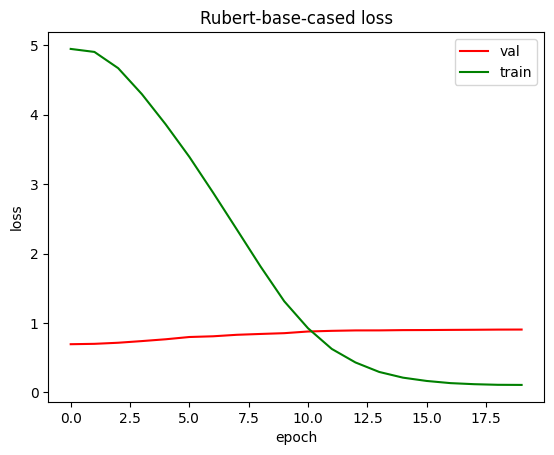

In [ ]:
graph(val_losses, train_losses, 'Rubert-base-cased loss', 'loss')

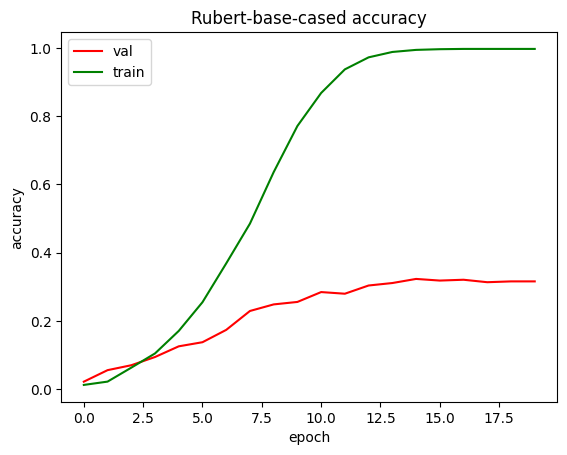

In [ ]:
graph(acc_val, acc_train,'Rubert-base-cased accuracy', 'accuracy')

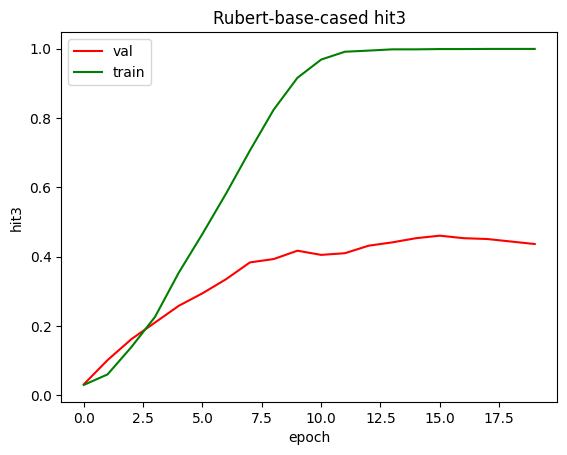

In [ ]:
graph(h3_val, h3_train,'Rubert-base-cased hit3', 'hit3')

In [ ]:
best_epoch_val, best_acc, best_hit3

(15, 0.3542168674698795, 0.4819277108433735)

In [ ]:
model.save_pretrained('out_path/rubert')

In [ ]:
del model;
del prediction_dataloader
del train_dataloader
del test_dataloader
gc.collect();
torch.cuda.empty_cache()

## **5. RuBioRoBERTa**

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(
    'alexyalunin/RuBioRoBERTa',
    do_lower_case=True,
    max_length=MAX_LEN
)

In [ ]:
batch_size = 4

In [ ]:
input_ids, attention_masks = encode_texts(tokenizer, sentences)

In [ ]:
prediction_dataloader,  train_dataloader, test_dataloader = preprocess_data(input_ids, attention_masks)

In [ ]:
model = RobertaForSequenceClassification.from_pretrained('alexyalunin/RuBioRoBERTa', num_labels=141)
model = model.cuda()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at alexyalunin/RuBioRoBERTa and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Обучениe модели

Обучение с помощью оптимизатора Adam. Функция потерь - кросс-энтропия.
Модель обучалась на 25 эпохах с циклическим уменьшением lr(начальный - lr = 3e-5)

In [ ]:
lr = 3e-5
epochs = 25
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)
criterion = nn.CrossEntropyLoss()

In [ ]:
h3_val, h3_train, val_losses, train_losses, best_epoch_val, best_acc, best_hit3, acc_val, acc_train = train(model, optimizer, scheduler, criterion)

  4%|▍         | 1/25 [15:39<6:15:47, 939.49s/it]

epoch  0 train_loss 4.985305603460972 acc 0.004819277108433735 hit3 0.03855421686746988


  8%|▊         | 2/25 [31:21<6:00:38, 940.79s/it]

epoch  1 train_loss 4.952921646891288 acc 0.012048192771084338 hit3 0.05301204819277108


 12%|█▏        | 3/25 [47:02<5:45:03, 941.06s/it]

epoch  2 train_loss 4.922094295229341 acc 0.02650602409638554 hit3 0.06987951807228916


 16%|█▌        | 4/25 [1:02:43<5:29:24, 941.17s/it]

epoch  3 train_loss 4.722508547954189 acc 0.07951807228915662 hit3 0.1855421686746988


 20%|██        | 5/25 [1:18:25<5:13:46, 941.31s/it]

epoch  4 train_loss 4.1705742941801605 acc 0.12771084337349398 hit3 0.2987951807228916


 24%|██▍       | 6/25 [1:34:07<4:58:07, 941.43s/it]

epoch  5 train_loss 3.5782435879255963 acc 0.18313253012048192 hit3 0.39759036144578314


 28%|██▊       | 7/25 [1:49:48<4:42:25, 941.42s/it]

epoch  6 train_loss 2.995752230823088 acc 0.2433734939759036 hit3 0.42650602409638555


 32%|███▏      | 8/25 [2:05:30<4:26:44, 941.46s/it]

epoch  7 train_loss 2.413149137667781 acc 0.3253012048192771 hit3 0.4987951807228916


 36%|███▌      | 9/25 [2:21:11<4:11:03, 941.47s/it]

epoch  8 train_loss 1.8007459699682602 acc 0.3421686746987952 hit3 0.5445783132530121


 40%|████      | 10/25 [2:36:53<3:55:22, 941.51s/it]

epoch  9 train_loss 1.3512917217176141 acc 0.3783132530120482 hit3 0.5301204819277109


 44%|████▍     | 11/25 [2:52:34<3:39:41, 941.51s/it]

epoch  10 train_loss 0.9380195476581918 acc 0.39518072289156625 hit3 0.5590361445783133


 48%|████▊     | 12/25 [3:07:15<3:20:00, 923.13s/it]

epoch  11 train_loss 0.6269583631593969 acc 0.3783132530120482 hit3 0.5493975903614458


 52%|█████▏    | 13/25 [3:22:57<3:05:45, 928.77s/it]

epoch  12 train_loss 0.40797892453647777 acc 0.41204819277108434 hit3 0.5518072289156627


 56%|█████▌    | 14/25 [3:38:39<2:50:59, 932.71s/it]

epoch  13 train_loss 0.2239961970989701 acc 0.41445783132530123 hit3 0.5662650602409639


 60%|██████    | 15/25 [3:54:21<2:35:54, 935.49s/it]

epoch  14 train_loss 0.1482107367985927 acc 0.43855421686746987 hit3 0.5783132530120482


 64%|██████▍   | 16/25 [4:09:02<2:17:52, 919.17s/it]

epoch  15 train_loss 0.08904755987164047 acc 0.43373493975903615 hit3 0.5542168674698795


 68%|██████▊   | 17/25 [4:23:44<2:01:03, 907.89s/it]

epoch  16 train_loss 0.06305206939935967 acc 0.40963855421686746 hit3 0.5590361445783133


 72%|███████▏  | 18/25 [4:38:25<1:44:59, 899.91s/it]

epoch  17 train_loss 0.061680635597864256 acc 0.44096385542168676 hit3 0.5734939759036145


 76%|███████▌  | 19/25 [4:54:07<1:31:14, 912.46s/it]

epoch  18 train_loss 0.037296279530100444 acc 0.4530120481927711 hit3 0.5879518072289157


 80%|████████  | 20/25 [5:08:48<1:15:15, 903.18s/it]

epoch  19 train_loss 0.0283876506479937 acc 0.4530120481927711 hit3 0.5831325301204819


 84%|████████▍ | 21/25 [5:23:30<59:46, 896.61s/it]  

epoch  20 train_loss 0.021856526413155965 acc 0.45542168674698796 hit3 0.5855421686746988


 92%|█████████▏| 23/25 [5:52:52<29:37, 888.78s/it]

epoch  22 train_loss 0.01730195503372211 acc 0.4433734939759036 hit3 0.5903614457831325


 96%|█████████▌| 24/25 [6:07:33<14:46, 886.48s/it]

epoch  23 train_loss 0.0164184645925005 acc 0.44819277108433736 hit3 0.5855421686746988


100%|██████████| 25/25 [6:22:14<00:00, 917.40s/it]

epoch  24 train_loss 0.014874504476749493 acc 0.44819277108433736 hit3 0.5855421686746988


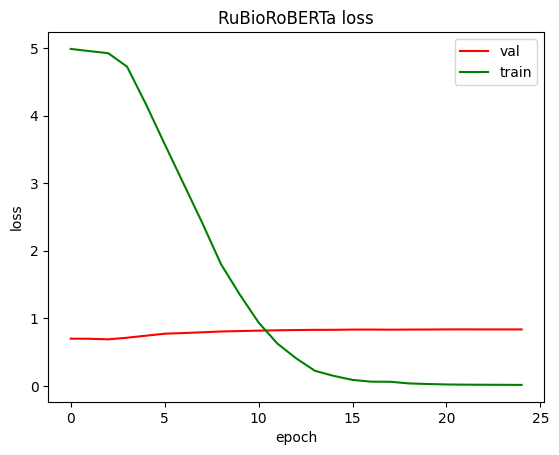

In [ ]:
graph(val_losses, train_losses, 'RuBioRoBERTa loss', 'loss')

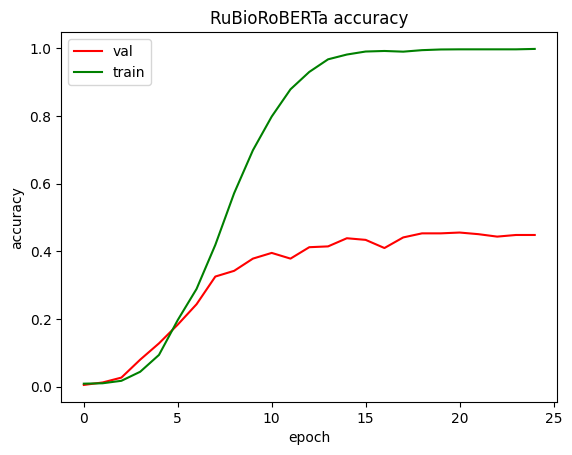

In [ ]:
graph(acc_val, acc_train,'RuBioRoBERTa accuracy', 'accuracy')

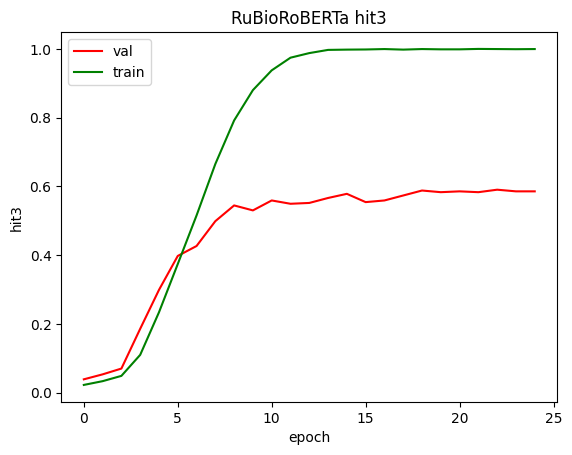

In [ ]:
graph(h3_val, h3_train,'RuBioRoBERTa hit3', 'hit3')

In [ ]:
best_epoch_val, best_acc, best_hit3

(18, 0.5012048192771085, 0.6265060240963856)

In [ ]:
model.save_pretrained('out_path/RuBioRoBERTa')

## **6) Пример работы модели**

Возьмем один из примеров. Текст примера содержит множество симптомов. Посмотрим, какие именно модель посчитает более релевантными.

In [ ]:
print(' TEXT:', sentences[6], '\n\n' , 'LABEL:', i2l[np.argmax(labels[6])])

 TEXT: жалобы сохраняются прежние : выраженные боли в правой руке, в правом плечевом суставе, локтевом суставе, ограничение движений в правом плечевом суставе, при движениях правой рукой : сгибании , разгибании, поднимании руки вверх - усиливаются боли в  и локтевом суставах по ВАШ 10 баллоов, также сохраняется боль и онемение 4 и 5 пальцев правой руки, простреливающего характера. Головные боли сохраняются, выраженные, преимущественно в затылочной области, постоянные. Лечение получает переносит хорошо. Уменьшились боли в шейном отделе позвоночника 

 LABEL: боль в области плеча


In [ ]:
model_predict = RobertaForSequenceClassification.from_pretrained('out_path/RuBioRoBERTa')

In [ ]:
def predict(sentence, k):
    input_ids, attention_masks = encode_texts(tokenizer, [sentences[6]])
    input_ids = torch.tensor(input_ids).long()
    attention_masks = torch.tensor(attention_masks).long()
    lab = torch.tensor([labels[0]], dtype=torch.float64)

    logit = model_predict(input_ids, attention_mask=attention_masks, labels=lab)[1]
    top_k = np.argsort(logit[0].detach())[-k:].numpy()
    result = [i2l[t] for t in top_k]

    return result[::-1]

In [ ]:
predict(sentences[0], 1)

['боль в области плеча']

In [ ]:
predict(sentences[0], 3)

['боль в области плеча', 'боль в области лопатки', 'стреляющая боль']

Как мы видим, модель достаточно точно определяет группу симптомов относящихся к тексту

## **7) Результаты**

Полученные результаты acc/hit@(%):

* RuBERT: 35.42, 48.19
* RuBioRoBERTa : 50.12, 62.65

Результаты превзошли метрики организаторов.

## **8) Ссылки на источники**

* [1] - https://arxiv.org/abs/2201.06499
* [2] - https://zenodo.org/records/5765873#.YbBlXT9Bzmw
* [3] - https://arxiv.org/abs/1905.07213
* [4] - https://arxiv.org/abs/2204.03951
* [5] - https://github.com/sb-ai-lab/MedBench/tree/main
* [6] - https://arxiv.org/pdf/1412.6980
* [7] - https://arxiv.org/pdf/1708.07120